# Imports

In [1]:
# Append location to path to allow custom modules to be used.
import sys, os
sys.path.append(os.path.abspath(os.path.join("..", "..")))

In [2]:
import cgael
from cgael.models.SimpleColor import *
from cgael.metrics import brevity

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layer

import pygad
import pygad.kerasga

import numpy as np
import pandas as pd

from PIL import Image

# Set Up

In [3]:
root_folder = os.path.join("C:",os.sep,"Users","nicho","PyProjects","CGAEL_Results")
experiment_folder = "single_simple_color_brevity"
experiment_prefix = "sscb"

In [4]:
os.makedirs(os.path.join(root_folder, experiment_folder), exist_ok=True)

In [5]:
ID_FORMAT = "{experiment_prefix}_{i}"

i = 1
while os.path.exists(os.path.join(root_folder, experiment_folder, f"{ID_FORMAT.format(experiment_prefix=experiment_prefix, i=i)}.npy")):
    i += 1
    
experiment_id = ID_FORMAT.format(experiment_prefix=experiment_prefix, i=i)
filename = f"{experiment_id}.npy"
filepath = os.path.join(root_folder, experiment_folder, filename)
print(filepath)

C:\Users\nicho\PyProjects\CGAEL_Results\single_simple_color_brevity\sscb_4.npy


# Training

In [6]:
ts = cgael.LanguageTokenSet("CHAT", '-')
gen = SimpleColorGenerator(
    [Swatch.WHITE, Swatch.BLACK, Swatch.RED, Swatch.GREEN, Swatch.BLUE, Swatch.YELLOW, Swatch.CYAN, Swatch.MAGENTA], 
    blur=0, batch_lock=True)
model = SimpleColorModel(token_set=ts, word_count=1, word_length=10, brevity_function=brevity.simple_brevity, brevity_weight=.25)

In [7]:
ga_inst = model.train(
    generator = gen,
    generations = 80,
    num_solutions = 50,
    num_parents_mating = 5,
    mutation_percent_genes = .1,
)

c:\Users\nicho\PyProjects\CGAEL\.conda\Lib\site-packages\pygad\pygad.py:909: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  warnings.warn("The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.")


Completed Generation: 1
Generating new batch...
Completed Generation: 2
Generating new batch...
Completed Generation: 3
Generating new batch...
Completed Generation: 4
Generating new batch...
Completed Generation: 5
Generating new batch...
Completed Generation: 6
Generating new batch...
Completed Generation: 7
Generating new batch...
Completed Generation: 8
Generating new batch...
Completed Generation: 9
Generating new batch...
Completed Generation: 10
Generating new batch...
Completed Generation: 11
Generating new batch...
Completed Generation: 12
Generating new batch...
Completed Generation: 13
Generating new batch...
Completed Generation: 14
Generating new batch...
Completed Generation: 15
Generating new batch...
Completed Generation: 16
Generating new batch...
Completed Generation: 17
Generating new batch...
Completed Generation: 18
Generating new batch...
Completed Generation: 19
Generating new batch...
Completed Generation: 20
Generating new batch...
Completed Generation: 21
Gene

In [8]:
np.save(filepath, np.array(model.model.get_weights(), dtype="object"))

# Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


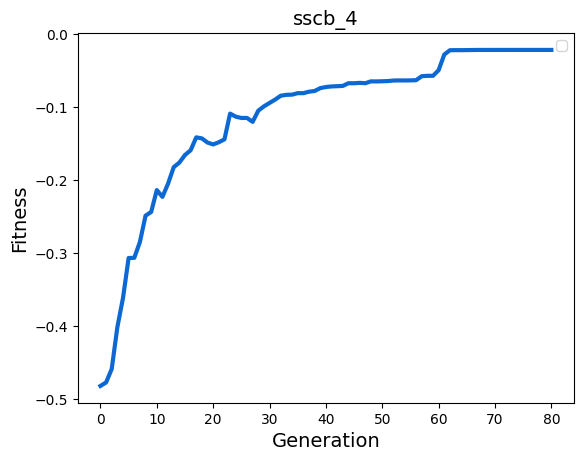

In [9]:
plot = ga_inst.plot_fitness(title=experiment_id, color="#0C69D3")
plot.savefig(os.path.join(root_folder, experiment_folder, f"{experiment_id}.png"))

In [10]:
KEY_SWATCH = "swatch"
KEY_TEXT = "text"
KEY_IN = "input"
KEY_OUT = "output"
KEY_ROUND = "output_rounded"

swatches = [Swatch.BLACK, Swatch.RED, Swatch.GREEN, Swatch.YELLOW, Swatch.BLUE, Swatch.MAGENTA, Swatch.CYAN, Swatch.WHITE]
samples = np.array([[sample_swatch(x)] for x in swatches])
lang, out = model.model(samples)
text = [ts.decode(x) for x in lang]

d = {x:[] for x in [KEY_SWATCH, KEY_TEXT, KEY_IN, KEY_OUT, KEY_ROUND]}
for s, t, i, o in zip(swatches, text, samples, out):
    d[KEY_SWATCH].append(s)
    d[KEY_TEXT].append(t)
    d[KEY_IN].append(i)
    o = o.numpy()
    d[KEY_OUT].append(o)
    o = np.round(o)
    d[KEY_ROUND].append(o)
df = pd.DataFrame(data=d)
display(df)

,swatch,text,input,output,output_rounded
0,Swatch.BLACK,C,"[[0.0, 0.0, 0.0]]","[[5.4791208e-08, 3.0263282e-06, 6.0870424e-14]]","[[0.0, 0.0, 0.0]]"
1,Swatch.RED,T,"[[0.0, 0.0, 1.0]]","[[6.746841e-08, 7.3681333e-10, 0.9999999]]","[[0.0, 0.0, 1.0]]"
2,Swatch.GREEN,CAC,"[[0.0, 1.0, 0.0]]","[[8.042203e-08, 0.9999969, 5.4187995e-12]]","[[0.0, 1.0, 0.0]]"
3,Swatch.YELLOW,H,"[[0.0, 1.0, 1.0]]","[[9.432518e-08, 0.99999934, 1.0]]","[[0.0, 1.0, 1.0]]"
4,Swatch.BLUE,CC,"[[1.0, 0.0, 0.0]]","[[0.9999992, 4.2306792e-07, 4.5327284e-11]]","[[1.0, 0.0, 0.0]]"
5,Swatch.MAGENTA,TC,"[[1.0, 0.0, 1.0]]","[[0.9999994, 1.0300315e-10, 1.0]]","[[1.0, 0.0, 1.0]]"
6,Swatch.CYAN,CAT,"[[1.0, 1.0, 0.0]]","[[1.0, 0.99999, 9.779312e-16]]","[[1.0, 1.0, 0.0]]"
7,Swatch.WHITE,HC,"[[1.0, 1.0, 1.0]]","[[0.9999996, 0.99999535, 1.0]]","[[1.0, 1.0, 1.0]]"


In [11]:
KEY_TEXT = "text"
KEY_OUT = "output"
KEY_ROUND = "output_rounded"

def generate_words(tokens, n):
    temp = tokens
    total = [''] + temp
    for _ in range(n-1):
        temp = [x+y for x in temp for y in tokens]
        total = total + temp
    return total

text = generate_words(ts.alphabet_tokens, 3)
data = np.array([ts.encode(x, shape=(1,3)) for x in text])
out = model.listener(data)

d = {x:[] for x in [KEY_TEXT, KEY_OUT, KEY_ROUND]}
for t, o in zip(text, out):
    d[KEY_TEXT].append(t)
    o = o.numpy()
    d[KEY_OUT].append(o)
    o = np.round(o)
    d[KEY_ROUND].append(o)
df = pd.DataFrame(data=d)
display(df)

ValueError: Input 0 of layer "listener" is incompatible with the layer: expected shape=(None, 1, 10), found shape=(85, 1, 3)